In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
from matplotlib import pyplot as plt
import os
import tensorflow as tf
import re
import sys

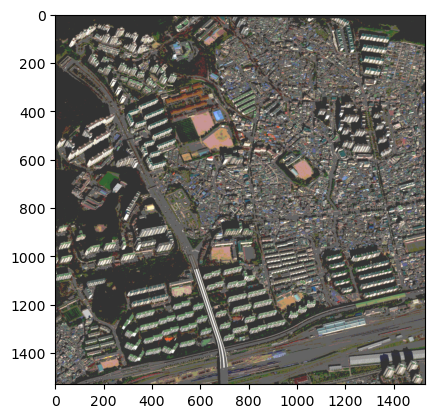

In [2]:

#import pictures and cut into slices
input_path = "../cse-seminar/inputs/tifBusan.tif"
img = cv2.imread(input_path)
img = cv2.convertScaleAbs(img, alpha = 50,beta = 50)
img = cv2.resize(img,(1530,1530))
plt.imshow(img)


# dimensions of the original image
height, width, _ = img.shape

# Define dimensions for each smaller image
small_width = width // 10
small_height = height // 10

# Slice the original image into smaller images
small_images = []
for row in range(10):
    for col in range(10):
        # starting and ending points of each small image
        start_x = col * small_width
        end_x = (col + 1) * small_width
        start_y = row * small_height
        end_y = (row + 1) * small_height

        # Extract from the original image
        small_image = img[start_y:end_y, start_x:end_x]

        # Append small image to list
        small_images.append(small_image)

# save smaller images
output_path = "../cse-seminar/small_images/"
for i, small_image in enumerate(small_images):
    cv2.imwrite( '../cse-seminar/small_images/small_image%d.png' % i, small_image)


In [3]:

# Set input shape
input_shape = (153, 153, 3)  # Assuming RGB images of size 320x320

# Build CNN model
model = Sequential()

# convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


# Flatten output from previous layer
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# Output layer
model.add(Dense(input_shape[0] * input_shape[1], activation='sigmoid'))  # Output mask with pixel-wise binary classification

# Reshape output to match input shape
model.add(tf.keras.layers.Reshape((input_shape[0], input_shape[1], 1)))

In [4]:
# Add Metrics
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.subtract(tf.add(y_true, y_pred), tf.multiply(y_true, y_pred)))
    iou_score = tf.divide(intersection, union)
    return iou_score


In [5]:

# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[iou]) #write new metric

In [6]:

# Load dataset and preprocess

folder_path = '../cse-seminar/small_images/'

# Initialize empty list to store image input paths
image_paths = []

# Iterate over files
for filename in os.listdir(folder_path):
    # Check if the file has a common image extension (e.g., jpg, png, etc.)
    if filename.lower().endswith('.png'):
        # Construct the full file path by joining the folder path and filename
        file_path = os.path.join(folder_path, filename)
        # Append the file path to the list of image paths
        image_paths.append(file_path)


images = []

for path in image_paths:
    img = load_img(path, target_size=input_shape[:2])
    img_array = img_to_array(img)
    images.append(img_array)

X = np.array(images)  # Convert into a numpy array



In [7]:

labels = np.zeros((X.shape[0],) + input_shape[:2], dtype=np.uint8)


labeled_data_path = '../cse-seminar/labeled_data/'
labeled_data = []

for filename in os.listdir(labeled_data_path):
    # Check if the file has a common image extension (e.g., jpg, png, etc.)
    if filename.lower().endswith('.npy'):
        # Construct the full file path by joining the folder path and filename
        file_path = os.path.join(labeled_data_path, filename)
        # Append the file path to the list of image paths
        labeled_data.append(file_path)

pattern = r"task-(\d+)-"
for i in range(0,len(labeled_data) - 1):
    match = re.search(pattern, labeled_data[i])
    result = int(re.sub(r"task-|-", "", match.group(0)),10)
    labels[result - 1] = np.load(labeled_data[i])

for i in range(0,len(labels) - 1):
    tmp = np.nonzero(labels[i])
    labels[i][tmp] = 1


In [8]:
# Split data into train and test
def normalize(input_image):
    return tf.cast(input_image, tf.float32) / 255.0

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

X_train = normalize(X_train)
X_test = normalize(X_test)


# Train
model.fit(X_train, y_train, batch_size=32, epochs=15, validation_split=0.2)

Epoch 1/15
2/2 [==============================] - 2s 676ms/step - loss: 0.6934 - iou: 0.3851 - val_loss: 0.6903 - val_iou: 0.1112
Epoch 2/15
2/2 [==============================] - 1s 450ms/step - loss: 0.6613 - iou: 0.3870 - val_loss: 0.6642 - val_iou: 0.1089
Epoch 3/15
2/2 [==============================] - 1s 367ms/step - loss: 0.4174 - iou: 0.4462 - val_loss: 0.6353 - val_iou: 0.0985
Epoch 4/15
2/2 [==============================] - 1s 399ms/step - loss: -0.3039 - iou: 0.7549 - val_loss: 0.9843 - val_iou: 0.0814
Epoch 5/15
2/2 [==============================] - 1s 413ms/step - loss: -1.7092 - iou: 1.8725 - val_loss: 2.1225 - val_iou: 0.0783
Epoch 6/15
2/2 [==============================] - 1s 396ms/step - loss: -6.3458 - iou: 3.0748 - val_loss: 3.4121 - val_iou: 0.0784
Epoch 7/15
2/2 [==============================] - 1s 410ms/step - loss: -10.6811 - iou: 3.1762 - val_loss: 4.4860 - val_iou: 0.0787
Epoch 8/15
2/2 [==============================] - 1s 413ms/step - loss: -11.0106 - io

1/1 [==============================] - 0s 87ms/step - loss: 4.2118 - iou: 0.1070


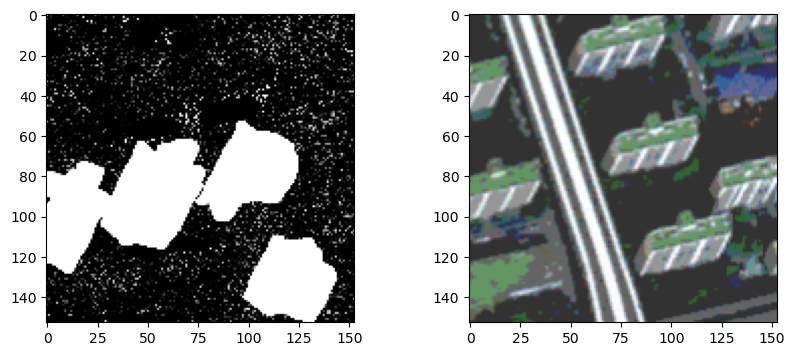

In [14]:

# predictions


predictions = model.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(predictions[0],cmap='gray')
ax2.imshow(X_test[0], cmap='gray')


# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
